In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import stats

from BorutaShap import BorutaShap

import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

In [2]:
cs2_odds_df = pd.read_pickle("dataframes/polished_mainframe.pkl")

# set datatype of every column to float, otherwise it will be 'type: object' and things won't work 
cs2_odds_df = cs2_odds_df.astype(float)

# # remove outliers
# cs2_odds_df = cs2_odds_df[np.abs(stats.zscore(cs2_odds_df['total_kills'])) < 3]

# split off results before normalization
cs2_odds_df_results = cs2_odds_df['total_kills']

# Split results between training, dev, and test
cs2_odds_df_training_results = cs2_odds_df_results.head((len(cs2_odds_df.index) * 7) // 10)
cs2_odds_df_dev_results = cs2_odds_df_results.iloc[((len(cs2_odds_df.index) * 7) // 10):((len(cs2_odds_df.index) * 9) // 10) - 1]
cs2_odds_df_test_results = cs2_odds_df_results.tail((len(cs2_odds_df.index) * 1) // 10)

cs2_odds_df.drop(columns=['total_kills'], axis=1, inplace=True)

In [3]:
# Normalize data before spltting off
cs2_odds_df=(cs2_odds_df-cs2_odds_df.min())/(cs2_odds_df.max()-cs2_odds_df.min())

# X_train, X_test, y_train, y_test = train_test_split(cs2_odds_df, y, test_size = 0.3, random_state = 0)

print(cs2_odds_df)

# Split data between training, dev, and test
cs2_odds_df_training = cs2_odds_df.head((len(cs2_odds_df.index) * 7) // 10)
cs2_odds_df_dev = cs2_odds_df.iloc[((len(cs2_odds_df.index) * 7) // 10):((len(cs2_odds_df.index) * 9) // 10) - 1]
cs2_odds_df_test = cs2_odds_df.tail((len(cs2_odds_df.index) * 1) // 10)

     team_rank  opponent_rank  kills_per_round  kills_per_round_win  \
215   0.365385       0.119231         0.581818             0.777778   
140   0.165385       0.511538         0.490909             0.513889   
182   0.226923       0.192308         0.672727             0.736111   
66    0.092308       0.107692         0.345455             0.347222   
43    0.434615       0.569231         0.509091             0.652778   
..         ...            ...              ...                  ...   
155   0.176923       0.053846         0.509091             0.541667   
41    0.046154       0.000000         0.472727             0.500000   
170   0.361538       0.700000         0.618182             0.791667   
168   0.261538       0.334615         0.400000             0.430556   
128   0.096154       0.169231         0.581818             0.569444   

     rounds_with_a_kill  rounds_with_a_multikill  damage_per_round  \
215            0.595918                 0.591549          0.662338   
140    

In [4]:
# Split off results
cs2_odds_df_training_results = cs2_odds_df_training_results.values.ravel()
cs2_odds_df_dev_results = cs2_odds_df_dev_results.values.ravel()
cs2_odds_df_test_results = cs2_odds_df_test_results.values.ravel()

In [5]:
from sklearn.model_selection import train_test_split

cs2_dmatrix_training = xgb.DMatrix(data=cs2_odds_df_training,label=cs2_odds_df_training_results)
cs2_dmatrix_dev = xgb.DMatrix(data=cs2_odds_df_dev,label=cs2_odds_df_dev_results)
cs2_dmatrix_test = xgb.DMatrix(data=cs2_odds_df_test,label=cs2_odds_df_test_results)

# import XGBClassifier
from xgboost import XGBRegressor


# declare parameters
params = {
            'max_depth': 4,
            # 'alpha': 10,
            'learning_rate': 0.01,
            'n_estimators':700,
            'eval_metric': 'rmse'
        }
            
            
            
# instantiate the classifier 
reg = XGBRegressor(**params)


# fit the classifier to the training data
reg.fit(cs2_odds_df_training, cs2_odds_df_training_results)

# dev set experimentation
score = reg.score(cs2_odds_df_dev, cs2_odds_df_dev_results)
print(f'XGB dev Score: {score}')
y_predicted = reg.predict(cs2_odds_df_dev)
rmse = np.sqrt(mean_squared_error(cs2_odds_df_dev_results, y_predicted))
print(f'XGB dev RMSE: {rmse}')

XGB dev Score: 0.1378120188013261
XGB dev RMSE: 7.803948719621405


In [6]:
#===========================================================================
# perform a scikit-learn Recursive Feature Elimination (RFE)
#===========================================================================
from sklearn.feature_selection import RFE
# here we want only one final feature, we do this to produce a ranking
n_features_to_select = 1
rfe = RFE(reg, n_features_to_select=n_features_to_select)
rfe.fit(cs2_odds_df_training, cs2_odds_df_training_results)

#===========================================================================
# now print out the features in order of ranking
#===========================================================================
from operator import itemgetter
features = cs2_odds_df_training.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)


#===========================================================================
# ok, this time let's choose the top 10 featues and use them for the model
#===========================================================================
n_features_to_select = 15
rfe = RFE(reg, n_features_to_select=n_features_to_select)
rfe.fit(cs2_odds_df_training, cs2_odds_df_training_results)

#===========================================================================
# use the model to predict the prices for the test data
#===========================================================================
# dev set experimentation
score = rfe.score(cs2_odds_df_dev, cs2_odds_df_dev_results)
print(f'XGB with feature removal dev Score: {score}')
y_predicted = rfe.predict(cs2_odds_df_dev)
rmse = np.sqrt(mean_squared_error(cs2_odds_df_dev_results, y_predicted))
print(f'XGB with feature removal dev RMSE: {rmse}')

1 rating
2 odds
3 rounds_with_a_kill
4 opponent_avg_rounds_won_in_losses
5 rounds_with_a_multikill
6 opponent_avg_rounds_lost_in_wins
7 avg_rounds_won_in_losses
8 avg_rounds_lost_in_wins
9 team_rank
10 damage_per_round_win
11 opponent_rank
12 win_percentage_after_opening_kill
13 opening_kills_per_round
14 kills_per_round_win
15 kills_per_round
16 trade_kills_percentage
17 opening_success
18 support_rounds
19 opening_deaths_traded_percentage
20 one_on_one_win_percentage
21 support_attacks_per_round
22 damage_per_kill
23 assisted_kills_percentage
24 damage_per_round
25 trade_kills_per_round
26 last_alive_percentage
27 opening_attempts
28 assists_per_round
29 traded_deaths_per_round
30 saved_by_teammate_per_round
31 traded_deaths_percentage
32 clutch_points_per_round
33 opening_deaths_per_round
34 saved_teammate_per_round
XGB dev Score: 0.17325785300797192
XGB dev RMSE: 7.641849209529806


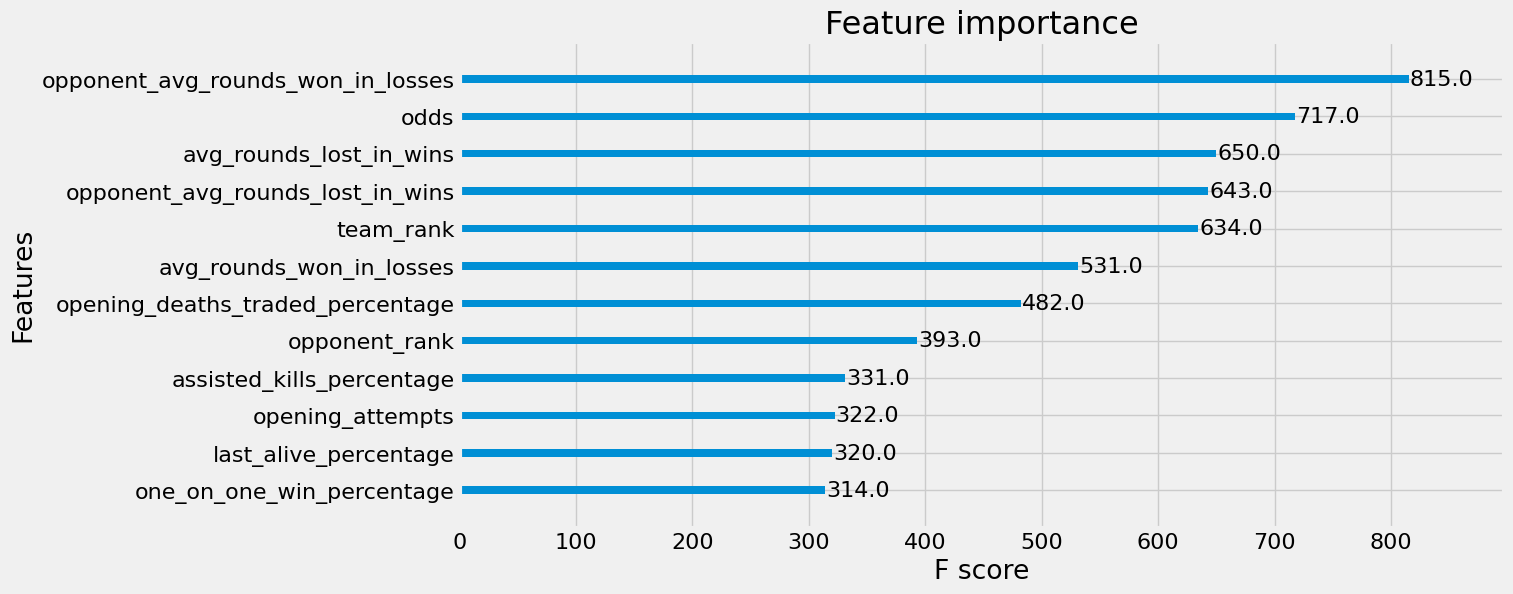

In [7]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(reg, max_num_features=12, ax=ax)
plt.show();

In [8]:
less_than_3_diff_count = 0
total_count = 0
for i in range(len(y_predicted)):
    if abs(y_predicted[i] - cs2_odds_df_dev_results[i]) < 3:
        less_than_3_diff_count += 1
    total_count+=1
print(less_than_3_diff_count)
print(less_than_3_diff_count / total_count)

172
0.2866666666666667


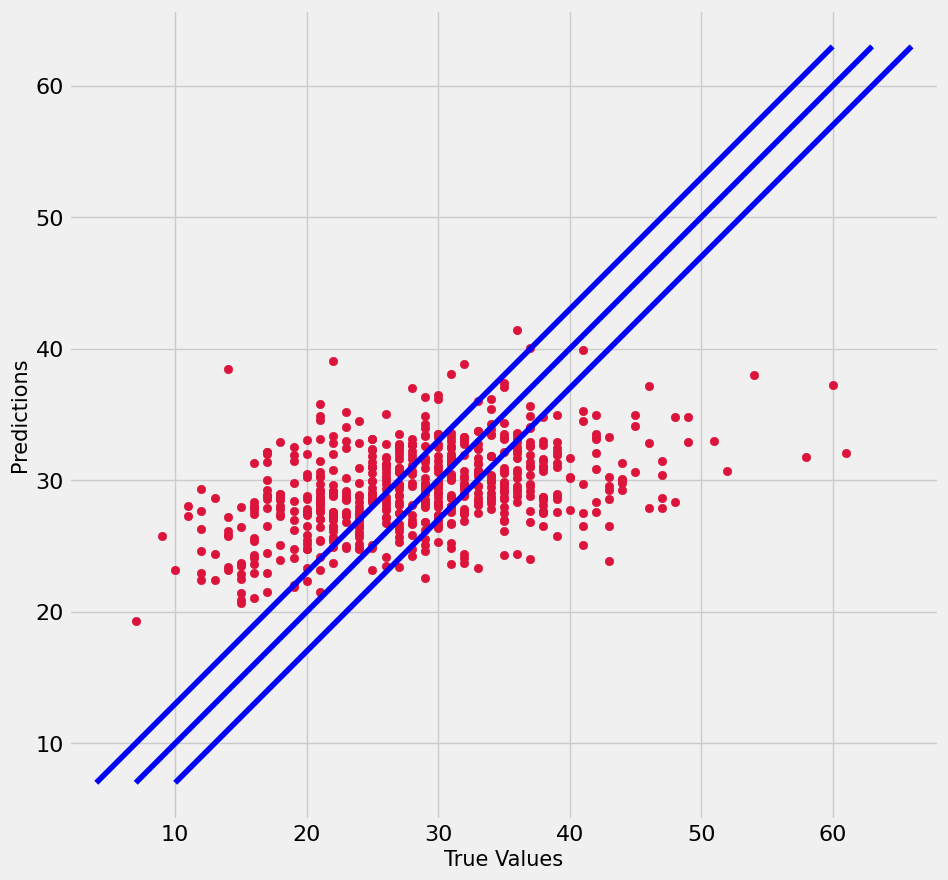

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(cs2_odds_df_dev_results, y_predicted, c='crimson')
p1 = max(max(y_predicted), max(cs2_odds_df_test_results))
p2 = min(min(y_predicted), min(cs2_odds_df_test_results))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.plot([p1+3, p2+3], [p1, p2], 'b-')
plt.plot([p1-3, p2-3], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [10]:
for i in range(len(cs2_odds_df_dev.columns)):
    print(f'{cs2_odds_df_dev.columns[i]}: {reg.feature_importances_[i]}')

team_rank: 0.017669005319476128
opponent_rank: 0.020552584901452065
kills_per_round: 0.031152309849858284
kills_per_round_win: 0.02806512638926506
rounds_with_a_kill: 0.06852047890424728
rounds_with_a_multikill: 0.03316015750169754
damage_per_round: 0.02609582617878914
damage_per_round_win: 0.027986736968159676
rating: 0.16734999418258667
saved_by_teammate_per_round: 0.01691364496946335
traded_deaths_per_round: 0.019394662231206894
traded_deaths_percentage: 0.017084134742617607
opening_deaths_traded_percentage: 0.022817740216851234
assists_per_round: 0.019286610186100006
support_rounds: 0.020439788699150085
saved_teammate_per_round: 0.015537894330918789
trade_kills_per_round: 0.03186094015836716
trade_kills_percentage: 0.025880422443151474
assisted_kills_percentage: 0.02194313332438469
damage_per_kill: 0.023982487618923187
opening_kills_per_round: 0.02746027149260044
opening_deaths_per_round: 0.01570204831659794
opening_attempts: 0.02092832885682583
opening_success: 0.02518136799335479

In [11]:
# for i in range(len(cs2_odds_df)):
#     print(f'{cs2_odds_df.columns[i]}: {reg.feature_importances_[i]}')

In [12]:
# test set results
reg.fit(cs2_odds_df_training, cs2_odds_df_training_results)
score = reg.score(cs2_odds_df_test, cs2_odds_df_test_results)
print(f'XGB test Score: {score}')
y_predicted = reg.predict(cs2_odds_df_test)
rmse = np.sqrt(mean_squared_error(cs2_odds_df_test_results, y_predicted))
print(f'XGB test RMSE: {rmse}')

XGB test Score: 0.1778900608849765
XGB test RMSE: 7.752064893848353


In [16]:
score = rfe.score(cs2_odds_df_test, cs2_odds_df_test_results)
print(f'XGB with feature removal test Score: {score}')
y_predicted = rfe.predict(cs2_odds_df_test)
rmse = np.sqrt(mean_squared_error(cs2_odds_df_test_results, y_predicted))
print(f'XGB with feature removal test RMSE: {rmse}')

XGB dev Score: 0.2027747023434867
XGB dev RMSE: 7.633838817106767


In [17]:
less_than_3_diff_count = 0
total_count = 0
for i in range(len(y_predicted)):
    if abs(y_predicted[i] - cs2_odds_df_test_results[i]) < 3:
        less_than_3_diff_count += 1
    total_count+=1
print(less_than_3_diff_count)
print(less_than_3_diff_count / total_count)

100
0.3333333333333333


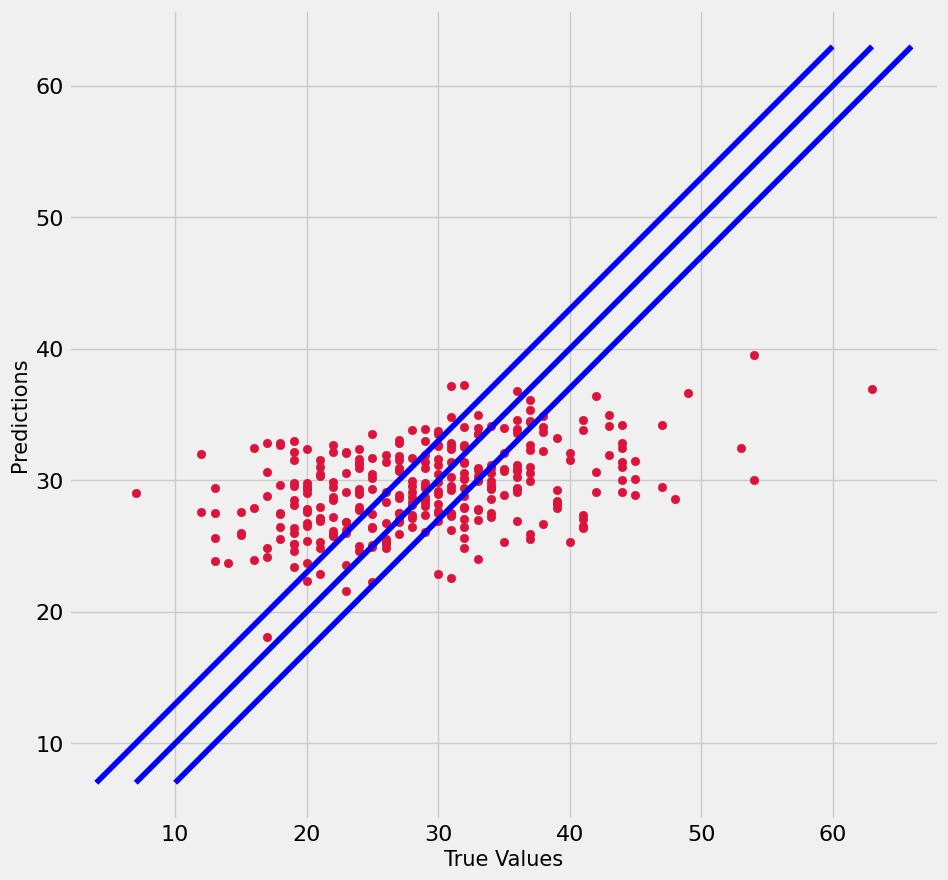

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(cs2_odds_df_test_results, y_predicted, c='crimson')
p1 = max(max(y_predicted), max(cs2_odds_df_test_results))
p2 = min(min(y_predicted), min(cs2_odds_df_test_results))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.plot([p1+3, p2+3], [p1, p2], 'b-')
plt.plot([p1-3, p2-3], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()